### Sistema de Recomendación

In [1]:
# Importar librerías:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import geopandas as gpd
from apyori import apriori
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
# Cargar dataset
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
data. head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [54]:
# Elimino filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['venta_total'] = data.Quantity * data.UnitPrice
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha y los minutos/segundos en columnas separadas
data['Date'] = data['InvoiceDate'].dt.date
data['minutos_segundos'] = data['InvoiceDate'].dt.time
# Elimino la columna (que no usaré) InvoiceDate:
data = data.drop(['InvoiceDate'], axis=1)

In [55]:
data_2 = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
data_2 = data_2.sort_values('venta_total',ascending=False)
data_2 = data_2[:21]
data_2.head(3)

,Country,Quantity,UnitPrice,CustomerID,venta_total
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06
24,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05
10,EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05


## Gráficos

<function matplotlib.pyplot.show(close=None, block=None)>

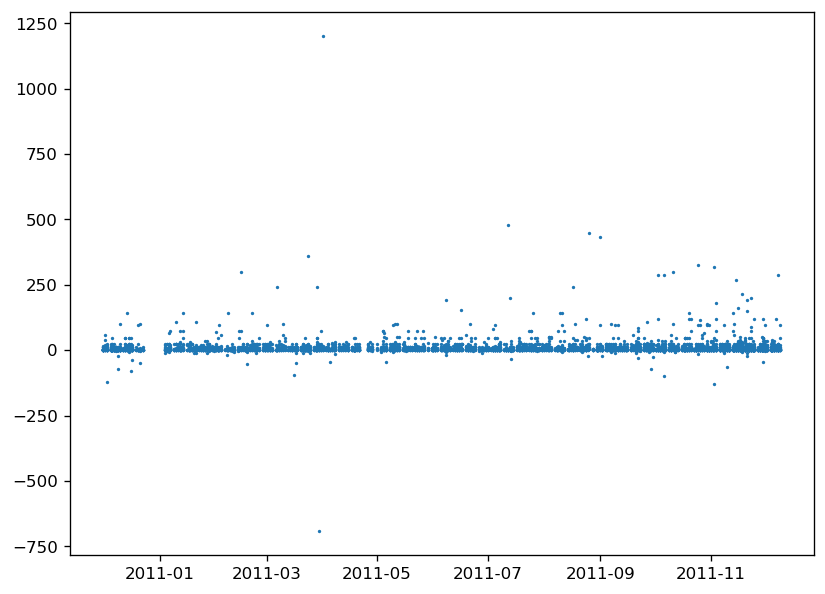

In [11]:
dataShort = data[::100]
plt.scatter(dataShort["Date"], dataShort["Quantity"] , s=1)
plt.show

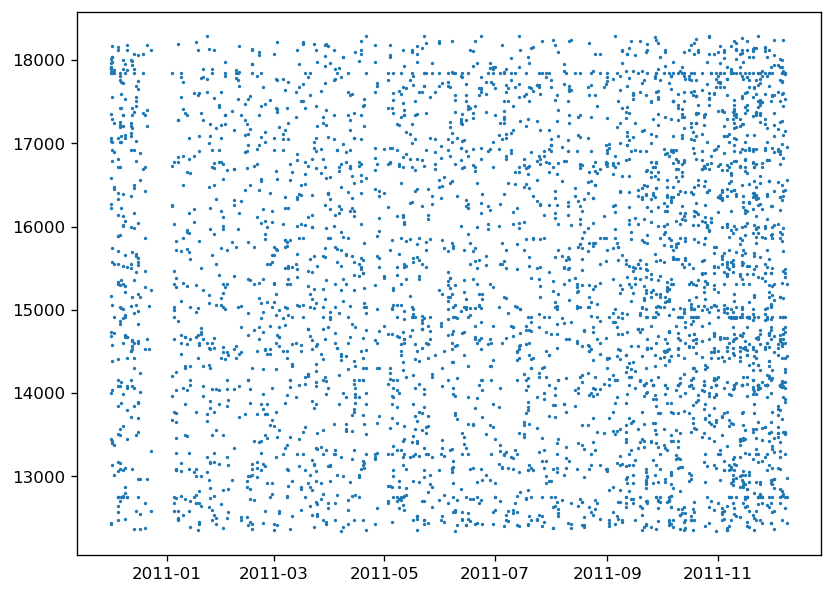

In [28]:
plt.scatter(dataShort["Date"], dataShort["CustomerID"], s=1)

In [56]:
data_2["logVentaTotal"] = np.log10(data_2["venta_total"])
data_2

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
...,...,...,...,...,...,...
30,Singapore,5234,2.510889e+04,2.918376e+06,9.120390e+03,3.960013


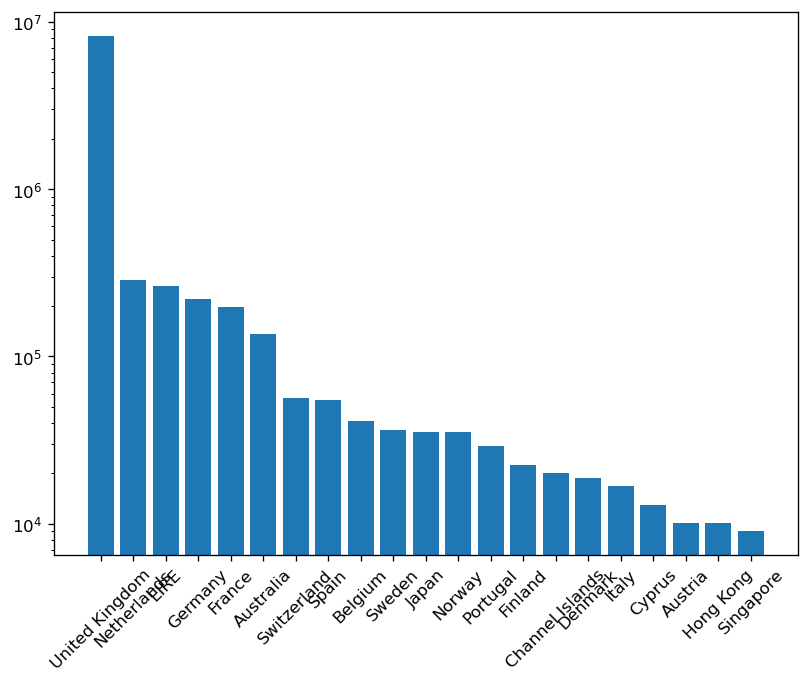

In [57]:
# Crear la gráfica de barras
plt.bar(data_2.Country, data_2['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

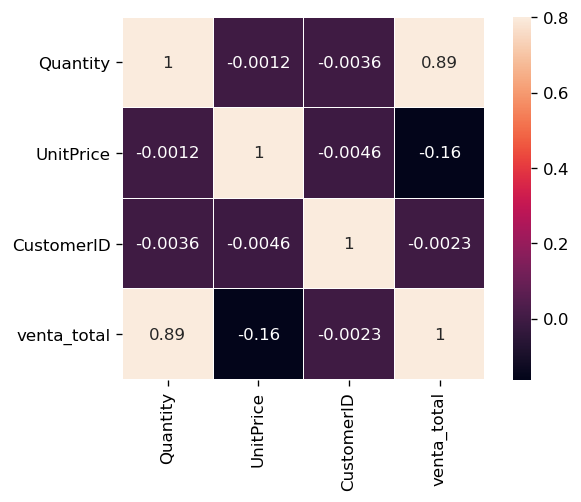

In [58]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

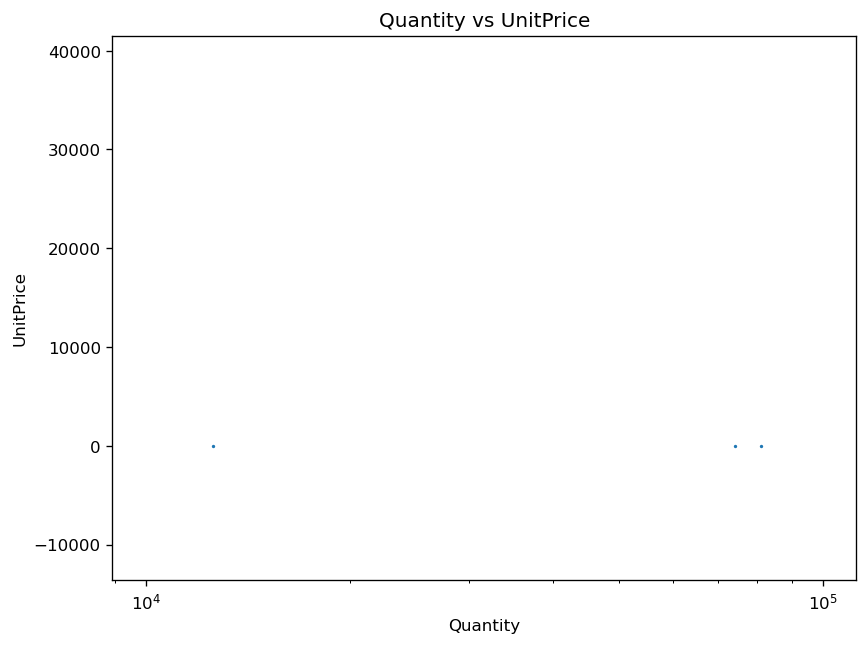

In [76]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(data['Quantity'], data['UnitPrice'], s=1)
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.xscale('log')
#plt.yscale('log')
plt.show()

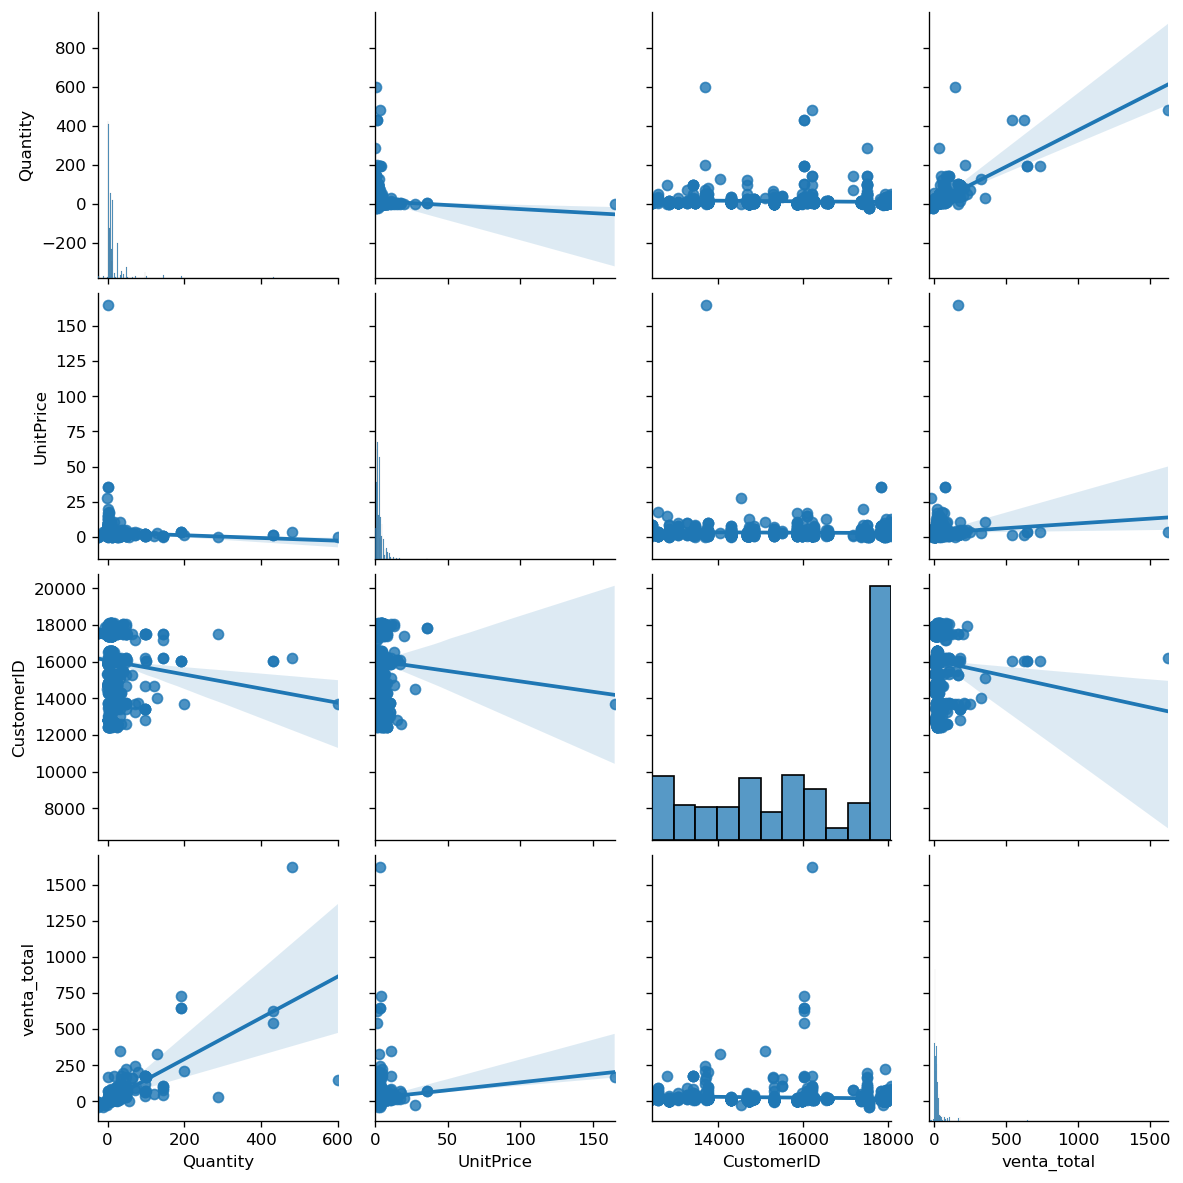

In [33]:
# Seaborn o PairGrid:
sns.pairplot(data[:1000], kind="reg")
plt.show()

In [60]:
data_vtas_totales_paises = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
data_vtas_totales_paises = data_vtas_totales_paises.sort_values('venta_total',ascending=False)
data_vtas_totales_paises["logVentaTotal"] = np.log10(data_vtas_totales_paises["venta_total"])
data_vtas_totales_paises

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
...,...,...,...,...,...,...
29,Saudi Arabia,75,2.411000e+01,1.256500e+05,1.311700e+02,2.117835


In [61]:
titles=''.join(str(data.Description)).lower()
titles

'0         white hanging heart t-light holder\n                         ...                \n541908         baking set 9 piece retrospot \nname: description, length: 541463, dtype: object'

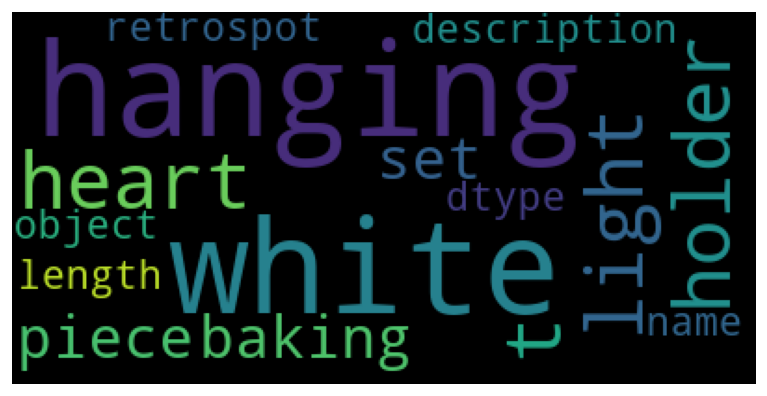

In [62]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [63]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Listado completo: pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0          Fiji
         ...   
176    S. Sudan
Name: name, Length: 177, dtype: object>

<AxesSubplot:>

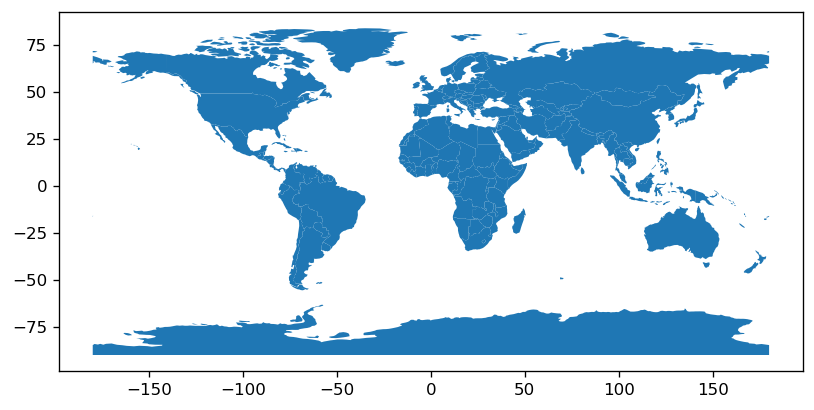

In [64]:
# Verificar si coincide los nombre de países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
#plt.show()   

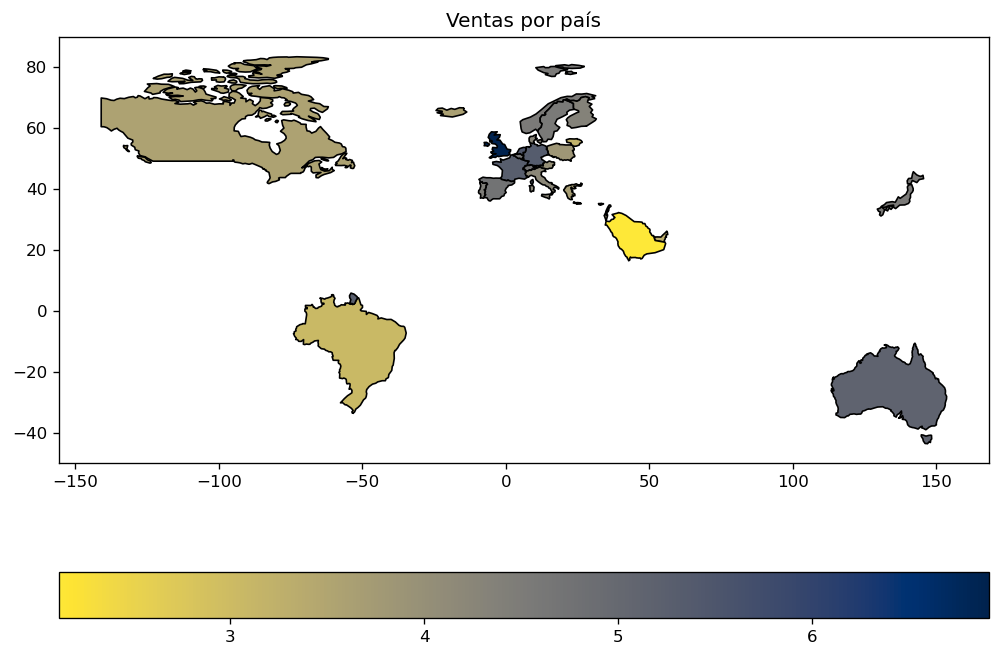

In [65]:
# Unir los datos de los países con los datos de ventas por país
data_merge = paises_geo_pandas.merge(data_vtas_totales_paises, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar los países en el mapa y colorearlos según las ventas
data_merge.plot(ax=ax, column='logVentaTotal', cmap='cividis_r', linewidth=0.99, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [ ]:
# Esto es una prueba
horas = pd.date_range(start=data['minutos_segundos'].min(),end=data['minutos_segundos'].max())
dfHoras = pd.DataFrame(['minutos_segundos: Horas'])
dfHoras

horario_vta_totales = data.groupby("minutos_segundos", group_keys=False, as_index=False).sum('venta_total')
# horario_vta_totales = horario_vta_totales.sort_values('venta_total',ascending=False)
# horario_vta_totales["logVentaTotal"] = np.log10(horario_vta_totales["venta_total"])
horario_vta_totales

# Crear la gráfica de barras
plt.bar(horario_vta_totales.minutos_segundos, horario_vta_totales['venta_total'])
# plt.xticks(rotation=45)
plt.show()


In [ ]:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')

In [11]:
calendario_cant_vta[calendario_cant_vta['Quantity'] < 0]

,Date,Quantity,UnitPrice,CustomerID,venta_total
152,2011-06-14,-13752,6435.36,16007436.0,40211.93


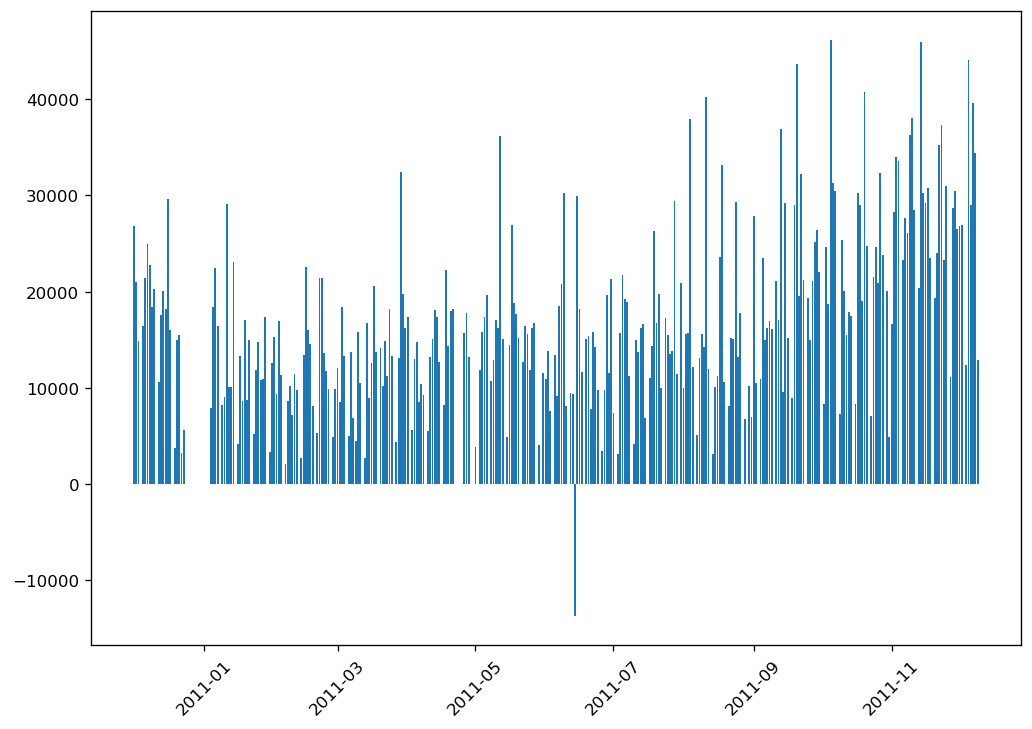

In [ ]:
# Crear la gráfica de barras
plt.bar(calendario_cant_vta.Date, calendario_cant_vta['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

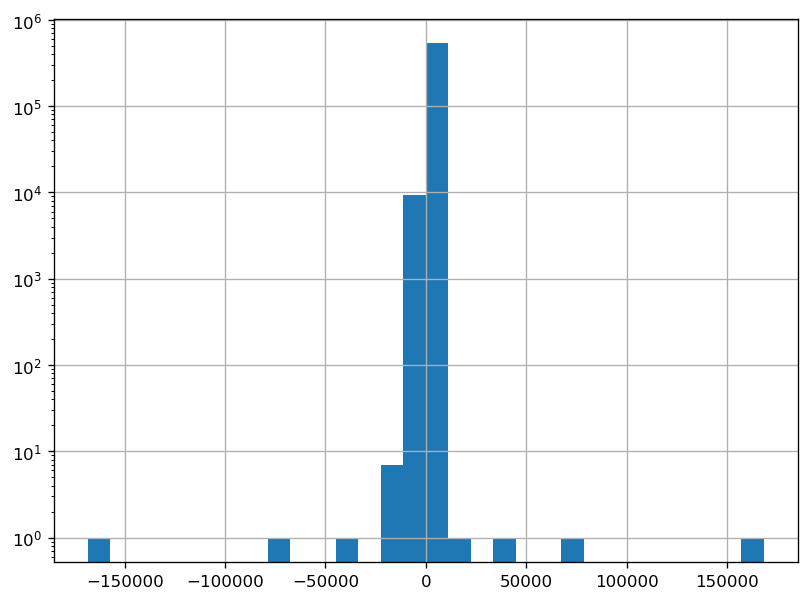

In [12]:
# Historama: Buscando bins más significativos (30 días = 1 mes)
data.venta_total.hist(bins=30)
plt.yscale('log')

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [17]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['StockCode'], aggfunc=np.sum)
Customer_Item.fillna(value=0, inplace=True)
Customer_Item

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


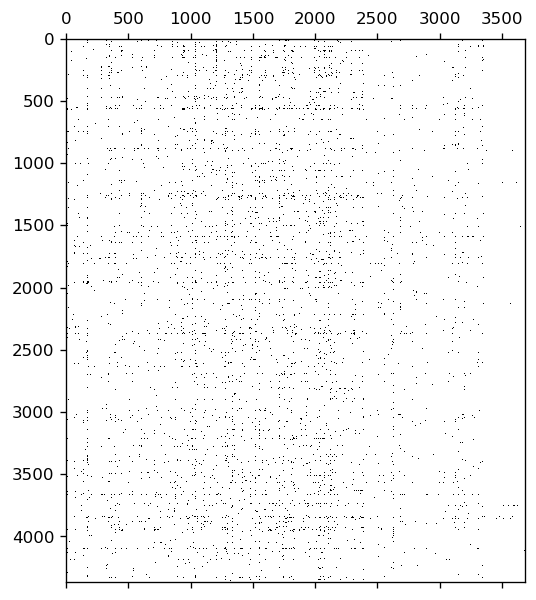

In [18]:
# Matriz para verificar queno todos los valores son NaN
plt.spy(Customer_Item)
plt.show()

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [19]:
distances = pdist(Customer_Item, metric="cosine")
distances

array([       nan,        nan,        nan, ..., 0.99622382, 1.        ,
       0.95555476])

In [20]:
cosineDistance = squareform(distances)
cosineDistance

array([[0.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.        , 0.85112109, ..., 0.98807888, 0.92548977,
        0.89105774],
       [       nan, 0.85112109, 0.        , ..., 1.        , 0.82482988,
        0.88990407],
       ...,
       [       nan, 0.98807888, 1.        , ..., 0.        , 0.99622382,
        1.        ],
       [       nan, 0.92548977, 0.82482988, ..., 0.99622382, 0.        ,
        0.95555476],
       [       nan, 0.89105774, 0.88990407, ..., 1.        , 0.95555476,
        0.        ]])

In [21]:
# Calculando la matriz user user:
cosineSimilarity = 1 - cosineDistance
cosineSimilarity

array([[1.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 1.        , 0.14887891, ..., 0.01192112, 0.07451023,
        0.10894226],
       [       nan, 0.14887891, 1.        , ..., 0.        , 0.17517012,
        0.11009593],
       ...,
       [       nan, 0.01192112, 0.        , ..., 1.        , 0.00377618,
        0.        ],
       [       nan, 0.07451023, 0.17517012, ..., 0.00377618, 1.        ,
        0.04444524],
       [       nan, 0.10894226, 0.11009593, ..., 0.        , 0.04444524,
        1.        ]])

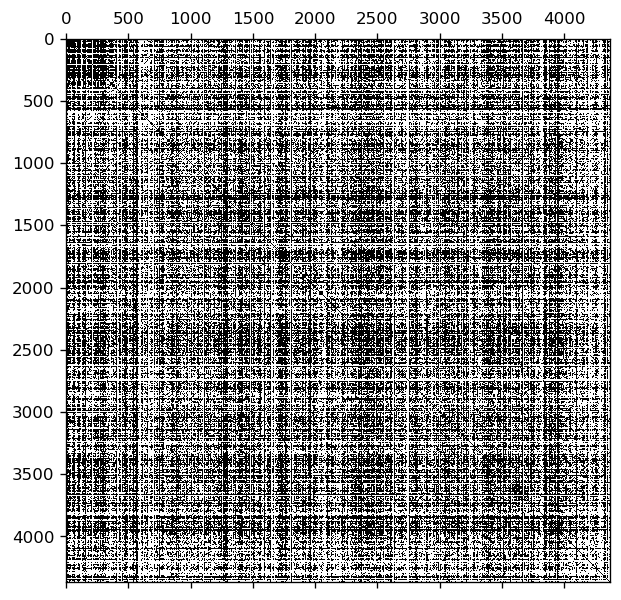

In [22]:
# Calculando la cantidad de usuarios. Matriz de user vs user:
cosineSimilarity.shape
plt.spy(cosineSimilarity)
plt.show()

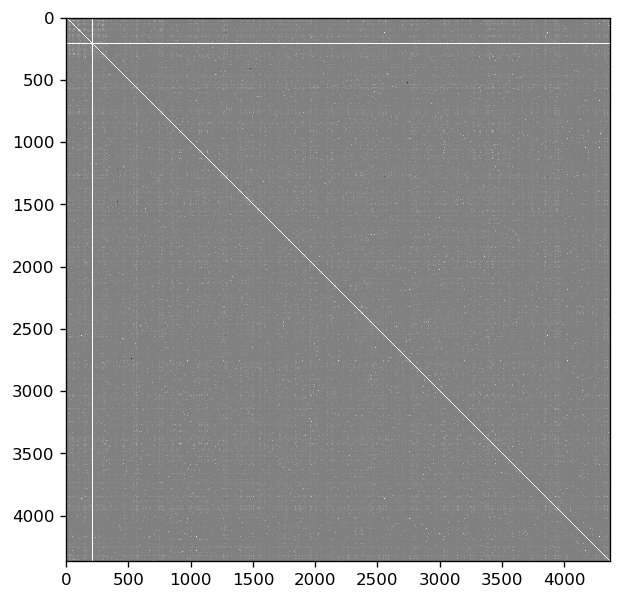

In [23]:
# Graficar matriz densa
plt.imshow(cosineSimilarity, cmap='gray', interpolation='nearest')
plt.show()

In [24]:
cosineSimilarity

array([[1.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 1.        , 0.14887891, ..., 0.01192112, 0.07451023,
        0.10894226],
       [       nan, 0.14887891, 1.        , ..., 0.        , 0.17517012,
        0.11009593],
       ...,
       [       nan, 0.01192112, 0.        , ..., 1.        , 0.00377618,
        0.        ],
       [       nan, 0.07451023, 0.17517012, ..., 0.00377618, 1.        ,
        0.04444524],
       [       nan, 0.10894226, 0.11009593, ..., 0.        , 0.04444524,
        1.        ]])

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [33]:
Customer_Item.index.to_list()

[12346.0,
 12347.0,
 12348.0,
 12349.0,
 12350.0,
 12352.0,
 12353.0,
 12354.0,
 12355.0,
 12356.0,
 12357.0,
 12358.0,
 12359.0,
 12360.0,
 12361.0,
 12362.0,
 12364.0,
 12365.0,
 12367.0,
 12370.0,
 12371.0,
 12372.0,
 12373.0,
 12374.0,
 12375.0,
 12377.0,
 12378.0,
 12379.0,
 12380.0,
 12381.0,
 12383.0,
 12384.0,
 12386.0,
 12388.0,
 12390.0,
 12391.0,
 12393.0,
 12394.0,
 12395.0,
 12397.0,
 12398.0,
 12399.0,
 12401.0,
 12402.0,
 12403.0,
 12405.0,
 12406.0,
 12407.0,
 12408.0,
 12409.0,
 12410.0,
 12412.0,
 12413.0,
 12414.0,
 12415.0,
 12417.0,
 12418.0,
 12420.0,
 12421.0,
 12422.0,
 12423.0,
 12424.0,
 12425.0,
 12426.0,
 12427.0,
 12428.0,
 12429.0,
 12430.0,
 12431.0,
 12432.0,
 12433.0,
 12434.0,
 12435.0,
 12436.0,
 12437.0,
 12438.0,
 12441.0,
 12442.0,
 12444.0,
 12445.0,
 12446.0,
 12447.0,
 12448.0,
 12449.0,
 12450.0,
 12451.0,
 12452.0,
 12453.0,
 12454.0,
 12455.0,
 12456.0,
 12457.0,
 12458.0,
 12461.0,
 12462.0,
 12463.0,
 12464.0,
 12465.0,
 12468.0,
 12471.0,


In [93]:
userUser = pd.DataFrame(cosine_similarity(Customer_Item))
userUser

In [95]:
userUser.iloc[0]

0       0.0
       ... 
4367    0.0
Name: 0, Length: 4368, dtype: float64

In [35]:
# este debe ser de la posición cero:
Customer_Item.index.to_list().index(18283.0)
# otro ejemplo:
Customer_Item.index.to_list().index(17850.0)
# duda:
Customer_Item.iloc[0]

4366

In [96]:
algo = Customer_Item.loc[18283.0, :]

In [97]:
ranking_ = algo.sort_values(ascending = False)
ranking_

StockCode
22418    46.0
         ... 
POST      0.0
Name: 18283.0, Length: 3684, dtype: float64

In [98]:
type(ranking_)

pandas.core.series.Series

In [99]:
similares = ranking_[(ranking_ > 0) & (ranking_ < 1)]
similares

Series([], Name: 18283.0, dtype: float64)

In [100]:
list(similares.index)

[]

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [ ]:
# 1.- En la práctica que vimos el índex del dataframe sería un contador. 
#En proyecto 4 el index podría ser el stockCode de los productos.
# 2.- En proyecto 4 ya tienes un dataframe con todo el texto en la columna "description": 
# tfidf_matrix = vectorizer.fit_transform(dfVentas["description"])
# 3.- Las recomendaciones serán el output después de calcular la matriz de similaridad. Primero debes escoger un usuario de ejemplo para el cuál realizar las recomendaciones. Luego buscar los N usuarios más parecidos a éste en la matriz de similaridad. 
# Luego sumar sus respectivos patrones de compra. Esa suma ordenada será el output de recomendaciones.

In [ ]:
# 1.- en este caso, quién sería mi index, lo creo o lo dejo el que tiene por default?
if data.StockCode:
    max_data = 0.5 # 0.50 means "ignore terms that appear in more than 50% of the documents"
    min_data = 3 # 3 means "ignore terms that appear in less than 3 documents"
else:
    max_data = 0.05 # 0.50 means "ignore terms that appear in more than 50% of the documents"
    min_data = 3 # 3 means "ignore terms that appear in less than 3 documents"

In [ ]:
# 2.- le dejo como dataframe el data o tengo que pasarle uno filtrado para este caso?
# Create TfidfVectorizer object
vectorizer = TfidfVectorizer(min_data=min_data, max_data=max_data, lowercase=True, stop_words = stopwords)
# Generate matrix of word vectors
tfidf_matrix = vectorizer.fit_transform("Description")
# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

In [ ]:
tokens = vectorizer.get_feature_names_out()
print(tokens)

In [ ]:
# 3.- Le (hardcodeo) paso manualmente una lista con las recomendaciones?
pregunta = "garch|MAPE|RMSE|LSTM|neural|rnn|forecasting|bilstm|arima|Tensorflow|Nonlinear|Random Forest|Knowledge 
 Discovery|word2vec|neural|nvidia|algorithms|algorithm|models|dataset|prediction|datasets|classification|nlp|gpus|
 modeling|artificial|python|caret|computing|lstm|computational|convolutional|gradient|proposes|bayesian|mining|graph|
 trained|gpt|inference|regression|dimensional|Machine Learning|Semantic Web|Natural Language Processing|sentiment 
 analysis|Artificial Intelligence|Linked Data|Named Entity Recognition|Data Science|Deep Learning|Data Mining"

 pregunta = "AI Is on the Brink of an 'iPhone Moment' and $15 Trillion Impact: BofA #artificial intelligence is on the brink of an 
 'iPhone moment' and can boost the world economy by $15.7 trillion in 7 years, Bank of America says Every sector will be impacted, 
 but the immediate beneficiaries include tech hardware (semis, #gpus, data centres), software (cloud, analytics) and cyber (phishing), 
 the strategists wrote. Meanwhile, UBS is #forecasting that the #artificial intelligence hardware and services market will reach $90 billion by 2025 . 
 In 2020, it was worth about $36 billion, per IDC and Bloomberg Intelligence data.  Our estimate may prove to be conservative as growth in [large language #models] 
 and other generative AI technologies could be even faster than we expect given advancements in #machineLearning and #deepLearning capabilities, UBS Global Wealth Management's 
 Solita Marcelli wrote in a client note Tuesday.  #bankOfAmerica #bloombergIntelligence #solitaMarcelli #ubsGlobalWealthManagement  
 https://markets.businessinsider.com/news/stocks/artificial-intelligence-ai-chatgpt-iphone-moment-bank-america-bofa-markets-2023-3"

preguntaVector = vectorizer.transform([pregunta])
preguntaVector

In [ ]:
# print(preguntaVector)
def vector2df(vector, tokens):
    dfPregunta = pd.DataFrame()

    # Obtener la frecuencia de cada token en la pregunta
    frecuencias = np.array(vector.sum(axis=0))[0]
    # Imprimir los tokens y sus frecuencias
    # La función zip(tokens, frecuencias) combina las listas tokens y frecuencias para formar una secuencia de tuplas
    for token, frecuencia in zip(tokens, frecuencias):
        if frecuencia > 0:
            # print(token, frecuencia)
            dfPregunta.loc[token, "frecuencia"] = frecuencia

    dfPregunta = dfPregunta.sort_values("frecuencia", ascending=False)
    return dfPregunta
vector2df(preguntaVector, tokens)

In [ ]:
coseno_similares = cosine_similarity(preguntaVector, tfidf_matrix)
coseno_similares
# Obtener el índice de los 10 mayores números de una lista
mejores_resultados = np.argsort(coseno_similares)[0]
mejores_resultados = np.flip(mejores_resultados)[:100] # inverse rearrange on numpy
mejores_resultados

In [ ]:
for i in mejores_resultados:
    print(i)
    print(coseno_similares[0][i])
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]
    print(vector2df(vector_documento, tokens)[:5])
print(pregunta)
print("\n")

for i in mejores_resultados:
    print('"' + df["textos"][i] + '"')
    print("\t - " + enlaces[i] + "\n")    
print(pregunta)
respuesta = textos[coseno_similares.argmax()]
print("\n\t" + respuesta)
# df["textos"][coseno_similares.argmax()]

In [ ]:
# Obtener los componentes importantes de un vector de características del documento de resultado
print(vector2df(tfidf_matrix[coseno_similares.argmax()], tokens)[:50])
# Obtener las keywords importantes de un vector de características del documento de resultado
# Obtener la primera columna del dataframe como lista
for i in vector2df(tfidf_matrix[coseno_similares.argmax()], tokens).index[:40].tolist():
    print(i + ", ", end='')

In [ ]:
# keywords importantes de los primeros resultados
keywords = []
for i in mejores_resultados:
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]

    for j in vector2df(vector_documento, tokens).index[:100].tolist():
        keywords.append(j)

In [ ]:
# Extraer los elementos de una lista ordenados por frecuencia descendiente
contador = Counter(keywords)
ordenados_por_frecuencia = sorted(contador.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# ordenados_por_frecuencia
for i in ordenados_por_frecuencia:
    print(i[0] + "|", end='')
print("\n")
for i in ordenados_por_frecuencia:
    print(i[0] + ", ", end='')            

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [ ]:
#mlens= pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
mlens = data.rename(columns={'CustomerID': "user_id", "StockCode" : "item_id", "UnitPrice" : "rating", "Date" : "timestamp"}, inplace=True)

In [ ]:
mlens = data.drop(["InvoiceNo", "Description", "Quantity", "Country"], axis=1)
mlens

,item_id,InvoiceDate,rating,user_id
0,85123A,12/1/2010 8:26,2.55,17850.0
1,71053,12/1/2010 8:26,3.39,17850.0
2,84406B,12/1/2010 8:26,2.75,17850.0
3,84029G,12/1/2010 8:26,3.39,17850.0
4,84029E,12/1/2010 8:26,3.39,17850.0
...,...,...,...,...
541904,22613,12/9/2011 12:50,0.85,12680.0
541905,22899,12/9/2011 12:50,2.10,12680.0
541906,23254,12/9/2011 12:50,4.15,12680.0
541907,23255,12/9/2011 12:50,4.15,12680.0


In [ ]:
# primero vamos a mapear los ids de usuario y de pelicula a un nuevo id que sea un indice
user2ix = {user:ix for ix,user in enumerate(mlens.user_id.unique())}
ix2user = {user2ix[k]:k for k in user2ix.keys()}

item2ix = {item:ix for ix,item in enumerate(mlens.item_id.unique())}
ix2item = {item2ix[k]:k for k in item2ix.keys()}

In [ ]:
mlens_con_ix = mlens.copy()

In [ ]:
# Eliminar los NaN: 
mlens_2 = mlens.notna()

In [ ]:
mlens_con_ix["user_id"] = mlens_2.user_id.apply(lambda x: user2ix[x])
mlens_con_ix["item_id"] = mlens_2.item_id.apply(lambda x: item2ix[x])

In [ ]:
# hacemos un pivot sobre el dataframe para tener la matriz usuario-item, esta no es la forma mas eficiente: estamos usando un dataframe
# pero pdist y cdist no toman una sparse matrix como input, para este problema no requerimos una sparse matrix necesariamente:
mlens_pivotada = mlens.pivot("item_id","user_id")["rating"]
# ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# calculando la similitud
similitudes = squareform(pdist(mlens_pivotada,metric=fast_cosine))

In [ ]:
# Función que devuelva el rating original si este existe, caso contrario, devuelve el predicho:
def predecir(user,item,similitudes,original,user2ix,item2ix):
    ix_user = user2ix[user]
    ix_item = item2ix[item]
    score = original.iloc[ix_item,ix_user]
    if np.isnan(score):
        item_similitudes = similitudes[:,ix_item]
        user_scores = original.iloc[:,ix_user].values
        k = np.nansum(item_similitudes[~np.isnan(user_scores)]) ## este es el denominador de la funcion
        
        if k == 0: 
            ## si nadie le puso puntaje al item o las similitudes son todas 0 devuelvo un score arbitrario
            return 2.5
        
        score = np.nansum(user_scores*item_similitudes)
        score = score/k
    return scoreuser = 554

In [ ]:
item = 651
predecir(user,item,similitudes,mlens_pivotada,user2ix,item2ix)